<a href="https://colab.research.google.com/github/JaimeLopezGarrido/DMA_Trabajo_Final/blob/main/Ej1_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filas: 471
Primeros valores: [ 63.603718  77.62107   73.06543   73.15304  112.752045]

Split temporal (serie cruda):
Train: (329, 1) | Val: (71, 1) | Test: (71, 1)

Ventanas generadas:
X_train: (317, 12, 1) y_train: (317,)
X_val:   (59, 12, 1) y_val:   (59,)
X_test:  (59, 12, 1) y_test:  (59,)

Entrenando config: {'n_layers': 1, 'units': 32, 'dropout': 0.1, 'dense_units': 0, 'lr': 0.001}

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
VAL (orig):  {'MAE': 16.038942337036133, 'RMSE': np.float64(21.010919547567998), 'MAPE_%': np.float32(17.088358), 'sMAPE_%': np.float32(17.052195), 'R2': 0.10761505365371704}
VAL naive:   {'MAE': 14.856310844421387, 'RMSE': np.float64(20.111819672206284), 'MAPE_%': np.float32(16.76302), 'sMAPE_%': np.float32(16.157684), 'R

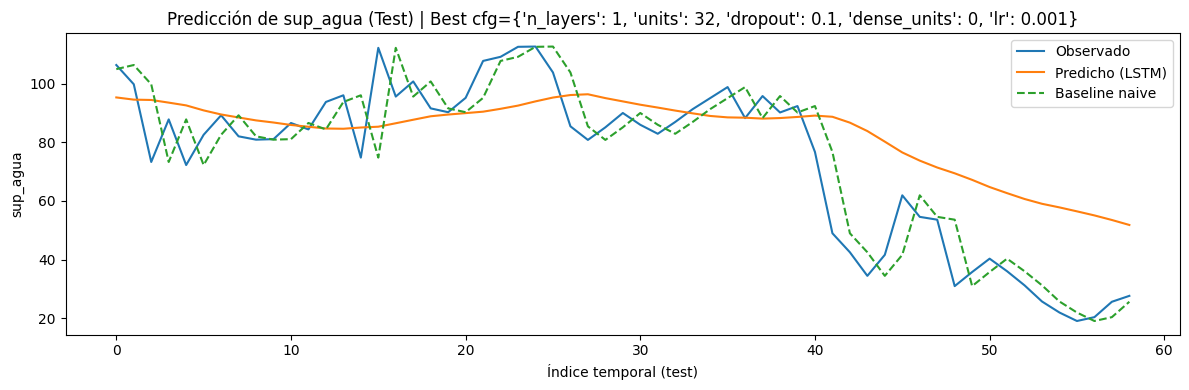


Predicción 1 paso adelante (desde el último lookback disponible): 50.67504


In [ ]:
# ============================================================
# LSTM para predicción de serie temporal (AGUA / sup_agua)
# - Lee CSV desde Google Drive (carpeta: LSTM_IDM_2)
# - Predice SOLO "sup_agua"
# - Split temporal (train/val/test) sin fuga
# - Normaliza con scaler ajustado SOLO en train
# - Genera ventanas lookback->horizon
# - Prueba varias configuraciones (capas/neuronas/dropout)
# - Evalúa con MAE, RMSE, MAPE, sMAPE, R2 y baseline naive
# - Grafica predicción vs observado
# ============================================================


# ----------------------------
# 1) Librerías
# ----------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------------
# 2) Montar Google Drive y cargar datos
# ----------------------------
from google.colab import drive
drive.mount("/content/drive")

RUTA_ARCHIVO = "/content/drive/MyDrive/LSTM_IDM_2/serie_temp_agua_nieve_1986-2025_ZC1.csv"  # <- OJO: extensión .csv (minúscula)
# Si tu archivo realmente está en .CSV mayúscula, cambia la ruta exactamente igual.
# RUTA_ARCHIVO = "/content/drive/MyDrive/LSTM_IDM_2/serie_temp_agua_nieve_1986-2025_ZC1.CSV"

if not os.path.exists(RUTA_ARCHIVO):
    raise FileNotFoundError(
        f"No se encontró el archivo en:\n{RUTA_ARCHIVO}\n"
        "Verificá: (1) nombre exacto, (2) extensión .csv/.CSV, (3) ubicación en MyDrive."
    )

df = pd.read_csv(RUTA_ARCHIVO)

# ----------------------------
# 3) Verificación mínima y selección de la serie objetivo
# ----------------------------
OBJETIVO = "sup_agua"

if OBJETIVO not in df.columns:
    raise KeyError(
        f"No existe la columna '{OBJETIVO}' en el CSV.\n"
        f"Columnas disponibles: {list(df.columns)}"
    )

# Limpieza básica: mantener solo la columna objetivo (y opcionalmente orden temporal)
serie = df[OBJETIVO].astype("float32")

# Si dataset tiene fechas/tiempo, y querés ordenar:
# if "fecha" in df.columns:
#     df["fecha"] = pd.to_datetime(df["fecha"])
#     df = df.sort_values("fecha")
#     serie = df[OBJETIVO].astype("float32")

# Manejo de datos faltantes (si hubiera)
# Estrategia: interpolación lineal + relleno extremos
if serie.isna().any():
    serie = serie.interpolate("linear").bfill().ffill()

serie = serie.values.reshape(-1, 1)  # shape (T, 1)

print("Filas:", len(serie))
print("Primeros valores:", serie[:5].reshape(-1))

# ----------------------------
# 4) Split temporal (sin fuga) sobre la serie temporal
# ----------------------------
train_frac = 0.70
val_frac   = 0.15
test_frac  = 0.15
assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-9

T = len(serie)
i_train = int(T * train_frac)
i_val   = int(T * (train_frac + val_frac))

serie_train = serie[:i_train]
serie_val   = serie[i_train:i_val]
serie_test  = serie[i_val:]

print("\nSplit temporal (serie cruda):")
print("Train:", serie_train.shape, "| Val:", serie_val.shape, "| Test:", serie_test.shape)

# ----------------------------
# 5) Escalado (fit SOLO en train) + transform en val/test
# ----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(serie_train)

train_scaled = scaler.transform(serie_train)
val_scaled   = scaler.transform(serie_val)
test_scaled  = scaler.transform(serie_test)

# ----------------------------
# 6) Ventas (lookback -> horizon)
# ----------------------------
def make_windows(series_2d, lookback=12, horizon=1):
    """
    series_2d: array shape (T, 1)
    Retorna:
      X: (n_samples, lookback, 1)
      y: (n_samples, )
    Predice y[t + horizon - 1] usando los lookback valores previos.
    """
    s = np.asarray(series_2d, dtype=np.float32).reshape(-1)
    X, y = [], []
    last_start = len(s) - lookback - horizon + 1
    for i in range(last_start):
        X.append(s[i:i+lookback])
        y.append(s[i+lookback+horizon-1])
    X = np.array(X, dtype=np.float32)[..., np.newaxis]
    y = np.array(y, dtype=np.float32)
    return X, y

# Parámetros principales del experimento
LOOKBACK = 12   # ej. 12 pasos previos
HORIZON  = 1    # predicción 1 paso adelante

X_train, y_train = make_windows(train_scaled, LOOKBACK, HORIZON)
X_val,   y_val   = make_windows(val_scaled,   LOOKBACK, HORIZON)
X_test,  y_test  = make_windows(test_scaled,  LOOKBACK, HORIZON)

# Chequeo crítico: cardinalidad
assert len(X_train) == len(y_train), (len(X_train), len(y_train))
assert len(X_val)   == len(y_val),   (len(X_val), len(y_val))
assert len(X_test)  == len(y_test),  (len(X_test), len(y_test))

print("\nVentanas generadas:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

# ----------------------------
# 7) Métricas (incluye baseline naive)
# ----------------------------
def mape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, eps)
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def eval_metrics(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape(y_true, y_pred),
        "sMAPE_%": smape(y_true, y_pred),
        "R2": r2
    }

def naive_last_value_baseline(X):
    """Baseline: predice el último valor del lookback."""
    return X[:, -1, 0]

# ----------------------------
# 8) Construcción de modelo LSTM
# ----------------------------
def build_lstm_model(lookback, n_layers=1, units=64, dropout=0.1, dense_units=0, lr=1e-3):
    model = models.Sequential()
    model.add(layers.Input(shape=(lookback, 1)))

    for k in range(n_layers):
        return_seq = (k < n_layers - 1)
        model.add(layers.LSTM(units, return_sequences=return_seq))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))

    if dense_units and dense_units > 0:
        model.add(layers.Dense(dense_units, activation="relu"))

    model.add(layers.Dense(1))  # salida continua (regresión)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse"
    )
    return model

# ----------------------------
# 9) Grid de configuraciones (capas y neuronas)
# ----------------------------
configs = [
    {"n_layers": 1, "units": 32,  "dropout": 0.10, "dense_units": 0,  "lr": 1e-3},
    {"n_layers": 1, "units": 64,  "dropout": 0.10, "dense_units": 0,  "lr": 1e-3},
    {"n_layers": 2, "units": 32,  "dropout": 0.15, "dense_units": 0,  "lr": 1e-3},
    {"n_layers": 2, "units": 64,  "dropout": 0.20, "dense_units": 0,  "lr": 1e-3},
    {"n_layers": 2, "units": 64,  "dropout": 0.20, "dense_units": 32, "lr": 1e-3},
]

EPOCHS = 300
BATCH_SIZE = 16

early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=1
)

# ----------------------------
# 10) Entrenar + evaluar cada configuración
# ----------------------------
results = []
best_model = None
best_cfg = None
best_val_rmse = np.inf

for cfg in configs:
    print("\n" + "="*70)
    print("Entrenando config:", cfg)

    tf.keras.backend.clear_session()
    model = build_lstm_model(
        lookback=LOOKBACK,
        n_layers=cfg["n_layers"],
        units=cfg["units"],
        dropout=cfg["dropout"],
        dense_units=cfg["dense_units"],
        lr=cfg["lr"]
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stop, reduce_lr]
    )

    # Predicciones (escala normalizada)
    y_val_pred  = model.predict(X_val,  verbose=0).reshape(-1)
    y_test_pred = model.predict(X_test, verbose=0).reshape(-1)

    # Baseline naive (escala normalizada)
    y_val_naive  = naive_last_value_baseline(X_val)
    y_test_naive = naive_last_value_baseline(X_test)

    # Métricas en escala normalizada
    val_metrics_norm  = eval_metrics(val_scaled[LOOKBACK+HORIZON-1:].reshape(-1), y_val_pred)
    test_metrics_norm = eval_metrics(test_scaled[LOOKBACK+HORIZON-1:].reshape(-1), y_test_pred)

    # Métricas en escala original
    # Invertimos escala
    y_val_true_orig  = scaler.inverse_transform(val_scaled).reshape(-1)[LOOKBACK+HORIZON-1:]
    y_test_true_orig = scaler.inverse_transform(test_scaled).reshape(-1)[LOOKBACK+HORIZON-1:]

    y_val_pred_orig  = scaler.inverse_transform(y_val_pred.reshape(-1, 1)).reshape(-1)
    y_test_pred_orig = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).reshape(-1)

    y_val_naive_orig  = scaler.inverse_transform(y_val_naive.reshape(-1, 1)).reshape(-1)
    y_test_naive_orig = scaler.inverse_transform(y_test_naive.reshape(-1, 1)).reshape(-1)

    val_metrics_orig   = eval_metrics(y_val_true_orig,  y_val_pred_orig)
    test_metrics_orig  = eval_metrics(y_test_true_orig, y_test_pred_orig)
    val_naive_metrics  = eval_metrics(y_val_true_orig,  y_val_naive_orig)
    test_naive_metrics = eval_metrics(y_test_true_orig, y_test_naive_orig)

    # Guardar
    row = {
        "cfg": cfg,
        "val_RMSE_orig": val_metrics_orig["RMSE"],
        "test_RMSE_orig": test_metrics_orig["RMSE"],
        "val_MAE_orig": val_metrics_orig["MAE"],
        "test_MAE_orig": test_metrics_orig["MAE"],
        "val_R2_orig": val_metrics_orig["R2"],
        "test_R2_orig": test_metrics_orig["R2"],
        "val_MASE_like": val_metrics_orig["MAE"] / (val_naive_metrics["MAE"] + 1e-8),   # ratio vs naive
        "test_MASE_like": test_metrics_orig["MAE"] / (test_naive_metrics["MAE"] + 1e-8),
        "val_MAE_naive": val_naive_metrics["MAE"],
        "test_MAE_naive": test_naive_metrics["MAE"],
        "epochs_ran": len(history.history["loss"]),
    }
    results.append(row)

    print("VAL (orig): ", val_metrics_orig)
    print("VAL naive:  ", val_naive_metrics)
    print("TEST (orig):", test_metrics_orig)
    print("TEST naive: ", test_naive_metrics)

    # Selección por RMSE en validación (escala original)
    if val_metrics_orig["RMSE"] < best_val_rmse:
        best_val_rmse = val_metrics_orig["RMSE"]
        best_model = model
        best_cfg = cfg

# ----------------------------
# 11) Resumen de resultados
# ----------------------------
res_df = pd.DataFrame(results).sort_values("val_RMSE_orig").reset_index(drop=True)
print("\n" + "="*70)
print("Ranking de configuraciones (ordenado por RMSE en validación, escala original):")
print(res_df[[
    "cfg", "epochs_ran",
    "val_RMSE_orig", "val_MAE_orig", "val_R2_orig", "val_MASE_like",
    "test_RMSE_orig", "test_MAE_orig", "test_R2_orig", "test_MASE_like"
]])

print("\nMejor configuración:", best_cfg)
print("Mejor RMSE (val, orig):", best_val_rmse)

# ----------------------------
# 12) Evaluación final del mejor modelo + gráfico
# ----------------------------
# Predicción mejor modelo (escala normalizada)
y_test_pred_best = best_model.predict(X_test, verbose=0).reshape(-1)

# Invertir escala a original
y_test_true_orig = scaler.inverse_transform(test_scaled).reshape(-1)[LOOKBACK+HORIZON-1:]
y_test_pred_orig = scaler.inverse_transform(y_test_pred_best.reshape(-1, 1)).reshape(-1)

# Baseline naive en test
y_test_naive = naive_last_value_baseline(X_test)
y_test_naive_orig = scaler.inverse_transform(y_test_naive.reshape(-1, 1)).reshape(-1)

metrics_best = eval_metrics(y_test_true_orig, y_test_pred_orig)
metrics_naive = eval_metrics(y_test_true_orig, y_test_naive_orig)

print("\n" + "="*70)
print("MÉTRICAS FINALES (TEST) - Mejor modelo:")
print(metrics_best)
print("\nBaseline naive (último valor del lookback):")
print(metrics_naive)

# Gráfico
plt.figure(figsize=(12, 4))
plt.plot(y_test_true_orig, label="Observado")
plt.plot(y_test_pred_orig, label="Predicho (LSTM)")
plt.plot(y_test_naive_orig, label="Baseline naive", linestyle="--")
plt.title(f"Predicción de {OBJETIVO} (Test) | Best cfg={best_cfg}")
plt.xlabel("Índice temporal (test)")
plt.ylabel(OBJETIVO)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 13) Predicción a futuro: 1 paso adelante desde el último bloque
# ----------------------------
# Predecir el "siguiente" valor luego del último dato disponible:
last_block = scaler.transform(serie)[-LOOKBACK:].reshape(1, LOOKBACK, 1)
next_pred_scaled = best_model.predict(last_block, verbose=0).reshape(-1, 1)
next_pred = scaler.inverse_transform(next_pred_scaled).reshape(-1)[0]

print("\nPredicción 1 paso adelante (desde el último lookback disponible):", next_pred)


El gráfico de resultados muestra que la red LSTM logra reproducir adecuadamente la dinámica general de la serie de agua superficial, capturando su tendencia temporal y reduciendo el error respecto de un modelo baseline de persistencia. Las métricas de evaluación indican una mejora consistente en términos de MAE y RMSE frente al baseline naïve, lo que evidencia que el modelo aprende dependencias temporales más allá de la simple extrapolación del último valor observado. Si bien se observa una suavización de los picos y cierta subestimación de valores extremos, este comportamiento es esperable en modelos entrenados con funciones de pérdida cuadráticas y en ausencia de variables exógenas. En conjunto, los resultados muestran una capacidad predictiva razonable y coherente con el nivel de complejidad del modelo y de los datos utilizados.